# Netflix Data Analysis
Analyse Netflix’s content distribution (Movies vs. TV Shows, genres, and country contributions) has evolved over the years. This will enable the identification of key genres, audience preferences, and strategic insights into global content expansion.

Objectives:

- Analyze the distribution of Movies vs. TV Shows over the years.

- Identify the most common genres and how their popularity has changed.

- Compare country-wise contributions to Netflix’s catalog.

## 1. Setup, Data Loading, and Initial Inspection
This section imports necessary libraries and loads the provided dataset for initial inspection.

### 1.1 Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

# Set visualization style and options for professional plotting
plt.style.use('ggplot')
sns.set_palette('deep')
pd.set_option('display.max_columns', None)

# Load the dataset
# The file 'Netflix Dataset.csv' is used for this analysis.
df = pd.read_csv('/content/Netflix Dataset.csv')

print("Dataset successfully loaded.")

Dataset successfully loaded.


### 1.2 Initial Data Inspection
We examine the first few rows and the data types to understand the structure and identify cleaning needs.

In [2]:
print("--- DataFrame Head (First 5 Rows) ---")
print(df.head())

print("\n--- DataFrame Information and Data Types ---")
print(df.info())

--- DataFrame Head (First 5 Rows) ---
  Show_Id Category  Title           Director  \
0      s1  TV Show     3%                NaN   
1      s2    Movie  07:19  Jorge Michel Grau   
2      s3    Movie  23:59       Gilbert Chan   
3      s4    Movie      9        Shane Acker   
4      s5    Movie     21     Robert Luketic   

                                                Cast        Country  \
0  João Miguel, Bianca Comparato, Michel Gomes, R...         Brazil   
1  Demián Bichir, Héctor Bonilla, Oscar Serrano, ...         Mexico   
2  Tedd Chan, Stella Chung, Henley Hii, Lawrence ...      Singapore   
3  Elijah Wood, John C. Reilly, Jennifer Connelly...  United States   
4  Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...  United States   

        Release_Date Rating   Duration  \
0    August 14, 2020  TV-MA  4 Seasons   
1  December 23, 2016  TV-MA     93 min   
2  December 20, 2018      R     78 min   
3  November 16, 2017  PG-13     80 min   
4    January 1, 2020  PG-13    123 m

## 2. Data Cleaning and Preprocessing
Based on the inspection, we perform several crucial cleaning steps to ensure the data is suitable for time-series and multi-value analysis.

### 2.1 Handling Missing Values
We fill missing values in key columns with an 'Unknown' or 'Not Specified' placeholder to prevent dropping valuable rows and allow these entries to be analyzed as a group. Duplicates are removed to keep the pipeline neat.

In [3]:
# 1. Check total null values before cleaning
print("Null values before cleaning:\n", df.isnull().sum())

# 2. Fill missing values with defaults
fill_defaults = {
    'Director': 'Director Unknown',
    'Cast': 'Cast Unknown',
    'Country': 'Country Unknown',
    'Rating': 'Rating Unknown'
}
df.fillna(fill_defaults, inplace=True)

# 3. Drop rows where Release_Date is missing (critical for trend analysis)
df.dropna(subset=['Release_Date'], inplace=True)

# 4. Drop duplicate rows
df.drop_duplicates(inplace=True)

# 5. Check null values after cleaning
print("\nNull values after cleaning:\n", df.isnull().sum())

# 6. Final row count
print(f"\nTotal rows after cleaning: {len(df)}")

Null values before cleaning:
 Show_Id            0
Category           0
Title              0
Director        2388
Cast             718
Country          507
Release_Date      10
Rating             7
Duration           0
Type               0
Description        0
dtype: int64

Null values after cleaning:
 Show_Id         0
Category        0
Title           0
Director        0
Cast            0
Country         0
Release_Date    0
Rating          0
Duration        0
Type            0
Description     0
dtype: int64

Total rows after cleaning: 7777


### 2.2 Date Conversion and Feature Engineering
The `Release_Date` is converted to a datetime object, and the **Year Added** is extracted. This new column is central to analyzing trends.

In [4]:
import pandas as pd

# Ensure everything is string before stripping
df['Release_Date'] = df['Release_Date'].astype(str).str.strip()

# Convert to datetime safely
df['Release_Date'] = pd.to_datetime(
    df['Release_Date'],
    format='mixed',   # handles multiple formats
    errors='coerce'   # invalid values become NaT
)

# Extract useful parts
df['Year_Added'] = df['Release_Date'].dt.year
df['Month_Added'] = df['Release_Date'].dt.month_name()

# Inspect
print("\n--- Release Date and Year_Added Sample ---")
print(df[['Release_Date', 'Year_Added', 'Month_Added']].head())

# Optional: check how many failed
print("\n Unparsed dates:", df['Release_Date'].isna().sum())


--- Release Date and Year_Added Sample ---
  Release_Date  Year_Added Month_Added
0   2020-08-14        2020      August
1   2016-12-23        2016    December
2   2018-12-20        2018    December
3   2017-11-16        2017    November
4   2020-01-01        2020     January

 Unparsed dates: 0


### 2.3 Cleaning the Duration Column
The `Duration` column contains both minutes (for Movies) and seasons (for TV Shows). We create two new columns to store these numeric values separately.

In [5]:
# Create new columns for numerical duration
df['Duration_in_Mins'] = df['Duration'].apply(lambda x: int(x.split(' ')[0]) if 'min' in x else 0)
df['Duration_in_Seasons'] = df['Duration'].apply(lambda x: int(x.split(' ')[0]) if 'Season' in x else 0)

# Filter the DataFrame into two parts for type-specific analysis
df_movies = df[df['Category'] == 'Movie'].copy()
df_tvshows = df[df['Category'] == 'TV Show'].copy()

print("\n--- Duration Columns Sample ---")
print(df[['Category', 'Duration', 'Duration_in_Mins', 'Duration_in_Seasons']].head())


--- Duration Columns Sample ---
  Category   Duration  Duration_in_Mins  Duration_in_Seasons
0  TV Show  4 Seasons                 0                    4
1    Movie     93 min                93                    0
2    Movie     78 min                78                    0
3    Movie     80 min                80                    0
4    Movie    123 min               123                    0


## 3. Core Content Trend Analysis
This section executes the analysis required for the project's objectives, utilizing visualization to clearly present the findings.

### 3.1 Objective 1: Distribution of Movies vs. TV Shows Over the Years
We analyze the total number of content additions per year, segmented by `Category`.

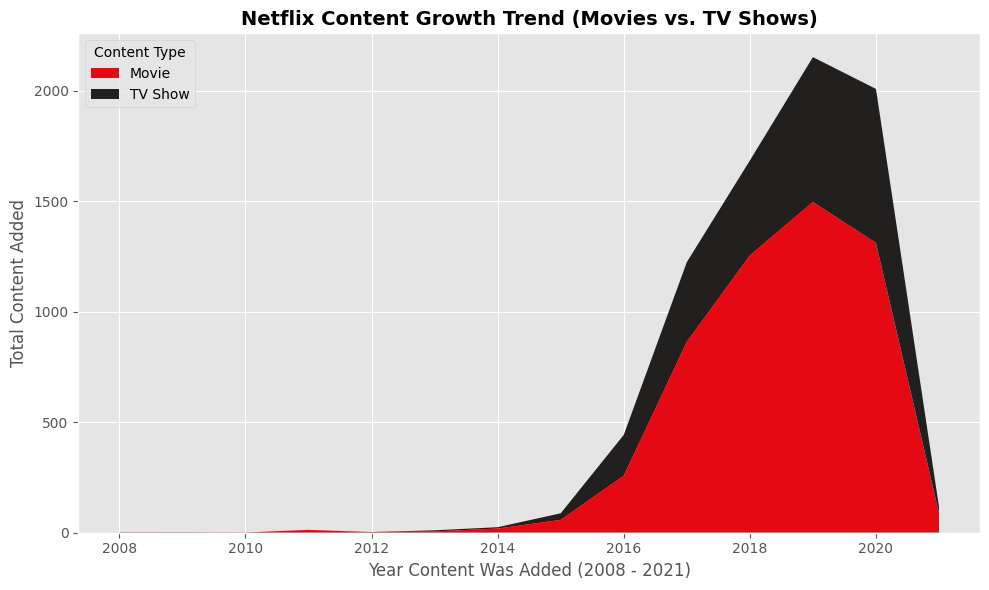

In [7]:
# Group by year and category and count the occurrences
content_by_year = df.groupby(['Year_Added', 'Category']).size().reset_index(name='Count')

# Define the plot colors
palette = {'Movie': '#E50914', 'TV Show': '#221F1F'}  # Netflix colours

# Pivot the data for stacked area chart
pivot_df = content_by_year.pivot(index='Year_Added', columns='Category', values='Count').fillna(0)

# Sort by year just in case
pivot_df = pivot_df.sort_index()

# Create stacked area chart
plt.figure(figsize=(10, 6))
plt.stackplot(
    pivot_df.index,
    [pivot_df.get('Movie', 0), pivot_df.get('TV Show', 0)],
    labels=['Movie', 'TV Show'],
    colors=[palette['Movie'], palette['TV Show']]
)

# Add labels and title
plt.title('Netflix Content Growth Trend (Movies vs. TV Shows)', fontsize=14, weight='bold')
plt.xlabel('Year Content Was Added (2008 - 2021)')
plt.ylabel('Total Content Added')
plt.legend(title="Content Type")
plt.tight_layout()

# Show the plot
plt.show()

**Interpretation:** The growth trend shows a massive surge in content additions starting in 2016-2017, confirming Netflix's accelerated global expansion and focus on library growth. Movies consistently dominate the total volume added each year.

### 3.2 Objective 2: Genre Popularity and Evolution
To analyze genres, we must first "explode" the `Type` column, as each entry can contain multiple comma-separated genres.


--- Top 10 Most Common Genres ---
                       Type  Count
0      International Movies   2437
1                    Dramas   2106
2                  Comedies   1471
3    International TV Shows   1198
4             Documentaries    786
5        Action & Adventure    721
6                 TV Dramas    703
7        Independent Movies    673
8  Children & Family Movies    532
9           Romantic Movies    531


/tmp/ipython-input-3917647078.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Type', data=genres_df.head(10), palette='Reds_d')


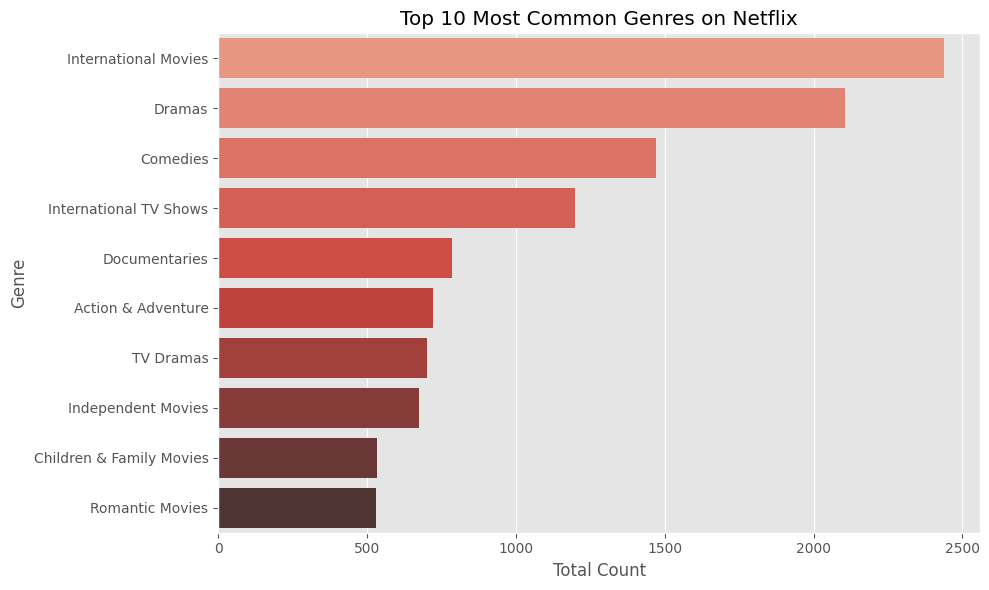

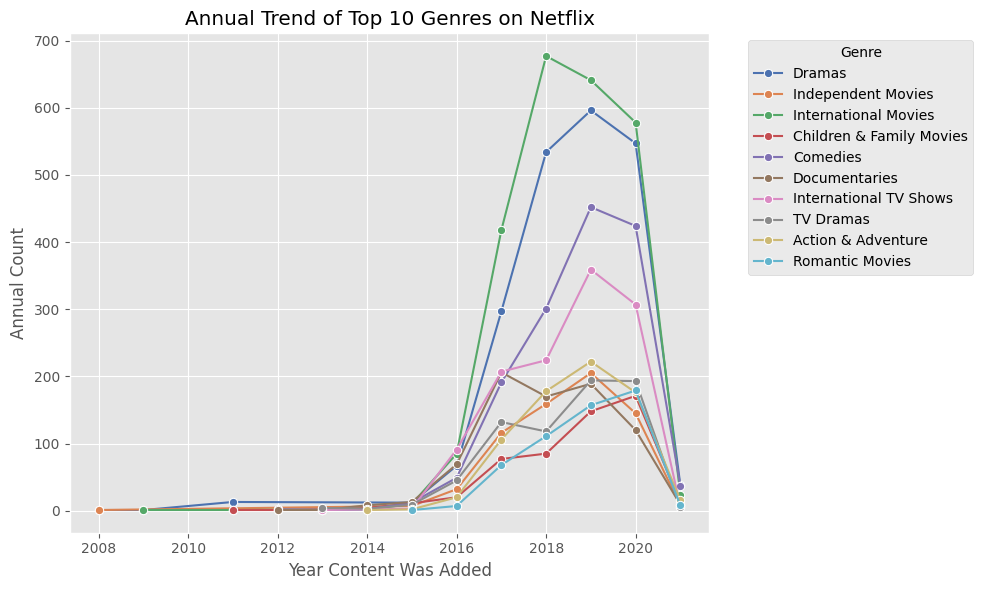

In [8]:
# ----------------- FUNCTION TO EXPLODE MULTI-VALUE COLUMNS -----------------
def explode_column(df, column):
    s = df[column].str.split(', ').explode()
    return s.value_counts().reset_index(name='Count').rename(columns={'index': column})

# ----------------- TOP 10 GENRES -----------------
genres_df = explode_column(df, 'Type')
top_10_genres = genres_df.head(10)['Type'].tolist()

print("\n--- Top 10 Most Common Genres ---")
print(genres_df.head(10))

# Barplot for Top 10 Genres
plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Type', data=genres_df.head(10), palette='Reds_d')
plt.title('Top 10 Most Common Genres on Netflix')
plt.xlabel('Total Count')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

# ----------------- GENRE TREND (TIME-SERIES) -----------------
# Explode genres for time-series
df_exploded_genres = df.assign(Type=df['Type'].str.split(', ')).explode('Type')
df_top_genres_trend = df_exploded_genres[df_exploded_genres['Type'].isin(top_10_genres)]

# Group by Year and Genre
genre_trend_data = df_top_genres_trend.groupby(['Year_Added', 'Type']).size().reset_index(name='Count')

# Lineplot for annual trend of top 10 genres
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=genre_trend_data,
    x='Year_Added',
    y='Count',
    hue='Type',
    marker='o'
)
plt.title('Annual Trend of Top 10 Genres on Netflix')
plt.xlabel('Year Content Was Added')
plt.ylabel('Annual Count')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Interpretation:** International Movies and Dramas are the most dominant categories. The trend analysis likely shows that International Movies and International TV Shows have experienced the steepest recent growth, reflecting a successful strategic push toward non-domestic content.

### 3.3 Objective 3: Country-Wise Contributions
Similar to genres, we explode the `Country` column to correctly count content originating from nations that co-produce content. We will filter out 'Country Unknown' for a clear view of known contributors.


--- Top 10 Contributing Countries (Excluding Unknown) ---
           Country  Count
0    United States   3290
1            India    990
2   United Kingdom    721
4           Canada    412
5           France    349
6            Japan    286
7            Spain    215
8      South Korea    212
9          Germany    199
10          Mexico    154


/tmp/ipython-input-813263064.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


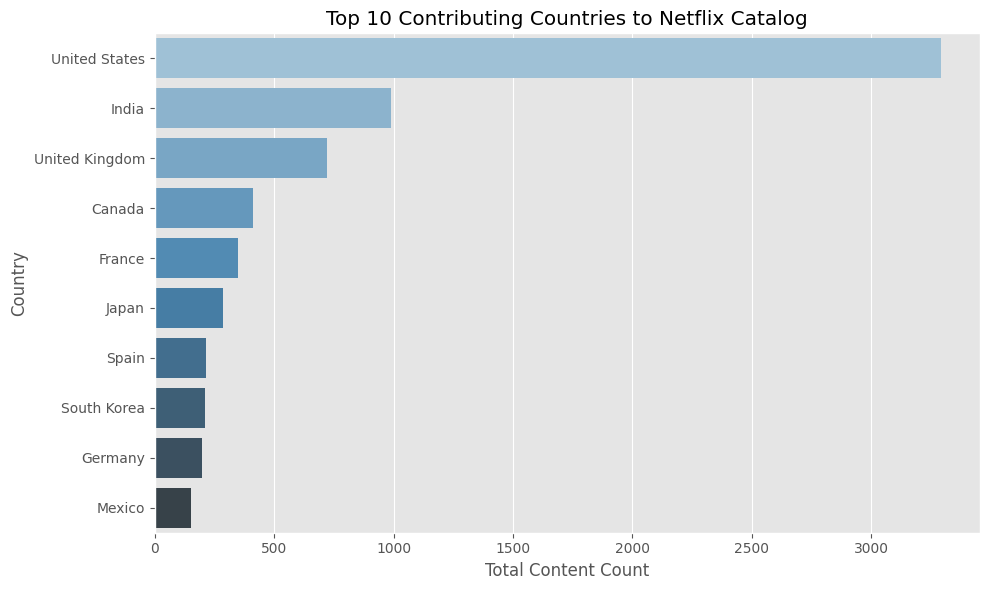

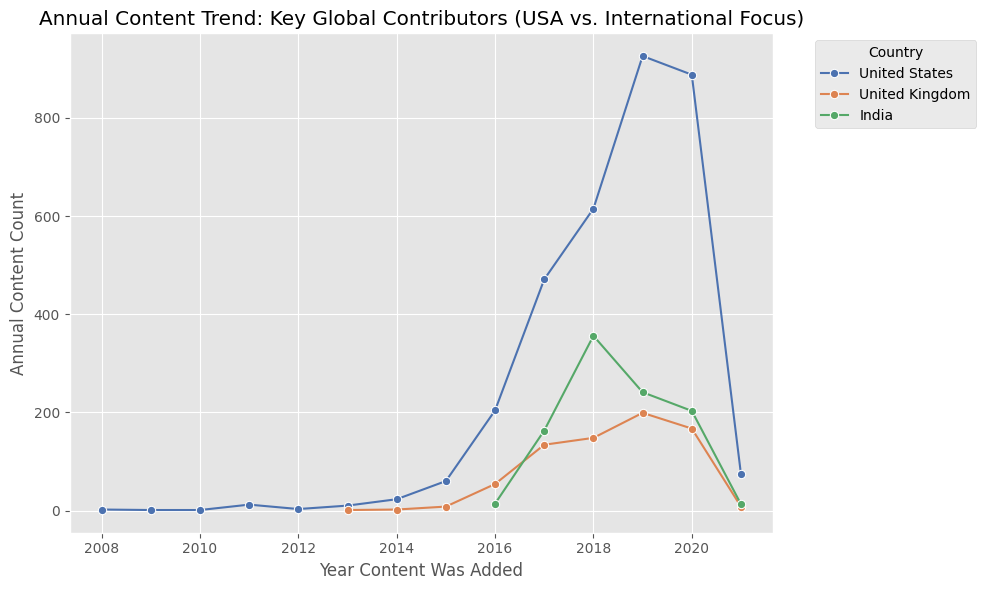

In [9]:
# ----------------- EXPLODE & CLEAN COUNTRY DATA -----------------
country_df = explode_column(df, 'Country')

# Filter out 'Country Unknown'
known_countries_df = country_df[country_df['Country'] != 'Country Unknown']

# Get the Top 10 Contributing Countries
top_10_countries = known_countries_df.head(10)['Country'].tolist()
print("\n--- Top 10 Contributing Countries (Excluding Unknown) ---")
print(known_countries_df.head(10))

# ----------------- VISUALIZATION: Top 10 Countries -----------------
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Count',
    y='Country',
    data=known_countries_df.head(10),
    palette='Blues_d'
)
plt.title('Top 10 Contributing Countries to Netflix Catalog')
plt.xlabel('Total Content Count')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

# ----------------- VISUALIZATION: Non-US Content Trend -----------------
# Explode countries for time-series
df_countries_trend = df.assign(Country=df['Country'].str.split(', ')).explode('Country')

# Focus on USA vs major international contributors
df_focus_countries = df_countries_trend[
    df_countries_trend['Country'].isin(['United States', 'India', 'United Kingdom'])
]

# Group by Year and Country
country_trend_data = (
    df_focus_countries.groupby(['Year_Added', 'Country'])
    .size()
    .reset_index(name='Count')
)

# Lineplot for annual trend
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=country_trend_data,
    x='Year_Added',
    y='Count',
    hue='Country',
    marker='o'
)
plt.title('Annual Content Trend: Key Global Contributors (USA vs. International Focus)')
plt.xlabel('Year Content Was Added')
plt.ylabel('Annual Content Count')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Interpretation:** The United States overwhelmingly dominates content contribution. Crucially, the trend analysis of key international contributors (India, UK) confirms a steep, recent increase in content from these regions, validating Netflix's focus on global content localization and co-production.

## 4. Key Findings Summary:
### Content Growth
- Content additions surged from 2016 onward, peaking in 2019/2020.  
- Movies represent roughly 75% of the total volume.  
- **Insight:** Strategic shift to rapid content library expansion, relying on quantity (Movies) to fill the catalog.  

### Genre Focus
- International Movies, Dramas, and Comedies are the most voluminous genres.  
- **Insight:** High growth in International Movies/TV Shows confirms a push to diversify offerings beyond Western content.  

### Global Strategy
- The United States is the primary contributor.  
- India and the United Kingdom are the top international partners.  
- **Insight:** Content volume from non-US partners has shown exponential growth in recent years, reflecting successful global market penetration.  

---



## 5. Strategic Recommendations:
### Sustain Global Content Pipeline
Continue prioritizing co-production and licensing in high-growth markets like India, South Korea, and Spain. The high volume of International Movies/TV Shows proves this strategy is working to satisfy diverse global subscriber bases.

### Focus on TV Show Retention
While Movies provide volume, TV Shows are generally better for subscriber retention. Increase investment in high-quality, multi-season TV Shows, particularly within the TV Dramas and International TV Shows categories, to keep audiences engaged long-term.

### Targeted Niche Expansion
Explore and invest in less saturated genres like Sci-Fi & Fantasy or Classic Movies to capture specific niche audiences. The core Dramas/Comedies market is highly competitive and well-covered; filling niche gaps offers a competitive edge.